# Test Task for BST

Я очень надеюсь, что никто не против комментариев на английском - мне так привычно

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

## Loading data

In [2]:
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()
pd.options.display.float_format = '{:.2f}'.format

In [3]:
df = pd.read_excel('BST_DataSet.xlsx', index_col = 0)

In [4]:
# long cyrillic name are evil incarnate
df = df.rename(columns = {
    'Прирост вкладов физических лиц в рублях (млн руб)' : 'target',
    'Доходность ОФЗ по сроку до 1 года' : 'profitability',
    'Ключевая ставка' : 'key_rate',
    'Ставка по вкладам в долларах до 1 года' : 'dollar_rate',
    # this one columns didn't want to rename the normal way
    df.columns[4]: 'ruble_rate',
    'Нефть марки Юралс, долл./барр' : 'oil_rate',
    'Индекс потребительских цен, ед.' : 'consumer_index',
    'М0, млрд руб' : 'm0',
    'М2, млрд руб' : 'm2',
    'Курс доллара к рублю, руб' : 'dollar2ruble',
    'Номинальная средняя з/п, руб' : 'avg_salary',
    }
    )

In [5]:
# dataset separation 
df_pred = df.loc[df['target'].isna()].copy()
df = df.drop(df[df['target'].isna()].index)

## Small EDA

In [6]:
df.head()

,target,profitability,key_rate,dollar_rate,ruble_rate,oil_rate,consumer_index,m0,m2,dollar2ruble,avg_salary
2011-01-01,-79049.00,5.24,7.75,2.90,4.50,96.29,106.17,5062.70,20011.90,30.08,20669
2011-02-01,180475.00,5.14,8.00,3.10,4.40,103.96,107.00,4830.70,19307.70,29.29,20680
2011-03-01,106845.00,5.02,8.00,3.10,4.20,114.44,107.66,4898.00,19536.70,28.43,22673
2011-04-01,224890.00,4.56,8.00,2.60,4.10,123.15,108.13,4918.20,19788.70,28.10,22519
2011-05-01,45856.00,4.79,8.25,2.60,4.10,114.46,108.64,5071.30,20020.80,27.87,22779


In [7]:
df.tail()

,target,profitability,key_rate,dollar_rate,ruble_rate,oil_rate,consumer_index,m0,m2,dollar2ruble,avg_salary
2016-08-01,92168.00,9.27,10.50,0.89,6.77,46.14,163.05,7462.39,36031.67,64.92,35405
2016-09-01,20272.00,9.02,10.00,0.82,6.00,46.19,163.33,7438.48,36169.58,64.60,35843
2016-10-01,72037.00,9.00,10.00,0.71,6.01,49.73,164.03,7412.20,36148.75,62.68,35749
2016-11-01,172323.00,8.94,10.00,0.72,6.62,46.44,164.75,7339.15,36051.04,64.36,36195
2016-12-01,889085.00,8.66,10.00,0.76,6.50,54.07,165.41,7317.23,36432.97,62.18,47554


In [8]:
df.describe()
# ight, might be usefull

,target,profitability,key_rate,dollar_rate,ruble_rate,oil_rate,consumer_index,m0,m2,dollar2ruble,avg_salary
count,72.00,72.00,72.00,72.00,72.00,72.00,72.00,72.00,72.00,72.00,72.00
mean,146640.50,7.85,9.15,2.43,6.30,87.86,131.48,6377.40,28298.09,43.11,30675.04
std,259385.69,2.36,2.38,1.00,1.86,29.88,19.80,713.38,4995.27,15.76,5451.28
min,-567448.00,4.56,5.50,0.71,4.00,30.80,106.17,4830.70,19307.70,27.87,20669.00
25%,19490.25,6.14,8.00,1.75,5.20,55.36,114.62,5936.78,24264.35,31.03,26561.25
50%,112924.50,6.55,8.25,2.55,5.71,105.47,125.21,6552.48,29196.30,33.24,30957.50
75%,236052.75,9.63,10.62,2.92,6.92,110.69,151.17,6880.30,31849.36,61.82,33880.00
max,1034556.00,15.10,17.00,5.22,12.33,124.93,165.41,7462.39,36432.97,77.22,47554.00


Эти два графика очень плохо ложатся друг на друга

Если кратко - рост по всем фронтам и там и там

<AxesSubplot:>

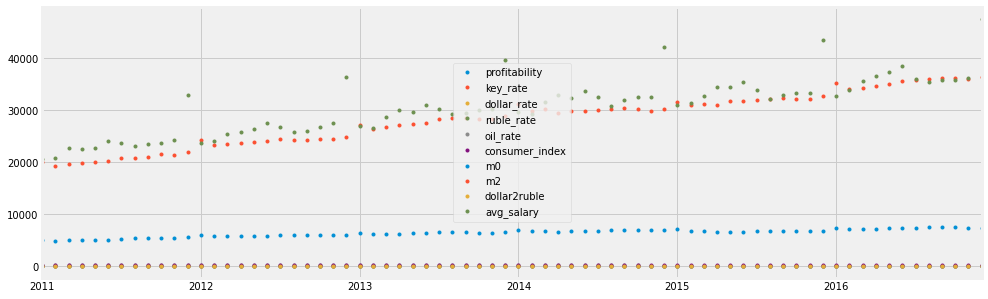

In [9]:
df.drop(columns = ['target']).plot(style = '.', figsize=(15,5))

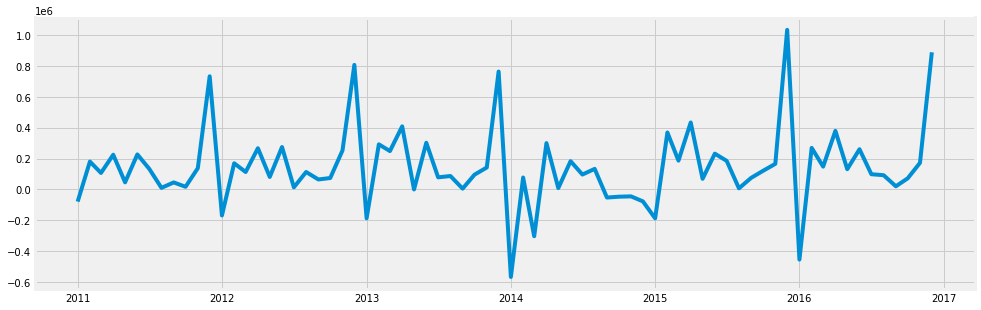

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
# ax.ticklabel_format(style='plain')
ax.plot(df['target'])
plt.show()

## Train/Test split

In [11]:
# taking the furthest year as test data
train = df.loc[df.index < '01-01.2016']
test = df.loc[df.index >= '01-01.2016']

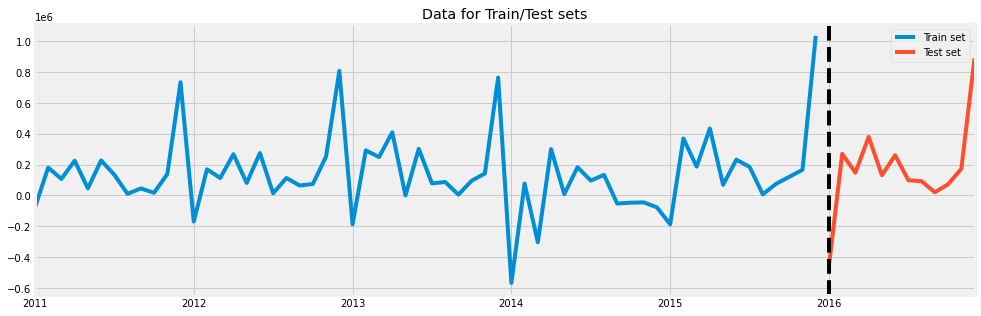

In [12]:
# plotting the above idea
fig, ax = plt.subplots(figsize = (15,5))
train['target'].plot(ax=ax, label = 'Train set')
test['target'].plot(ax=ax, label = 'Test set')
ax.axvline('01-01.2016', color = 'black', ls = '--')
ax.legend(['Train set', 'Test set'])
ax.set_title('Data for Train/Test sets')
plt.show()

## Feature creation

In [13]:
# 'ymd' date itself is a bad data structure for ml
def create_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    return df

In [14]:
df = create_features(df)

## Features / Targer relationship

In [15]:
def plot_feature_target_relationship(feature_name):
    fig, ax = plt.subplots(figsize = (15,8))
    sns.boxplot(data=df, x=feature_name, y='target', ax=ax)
    ax.set_title(f'Target/{feature_name} relation')


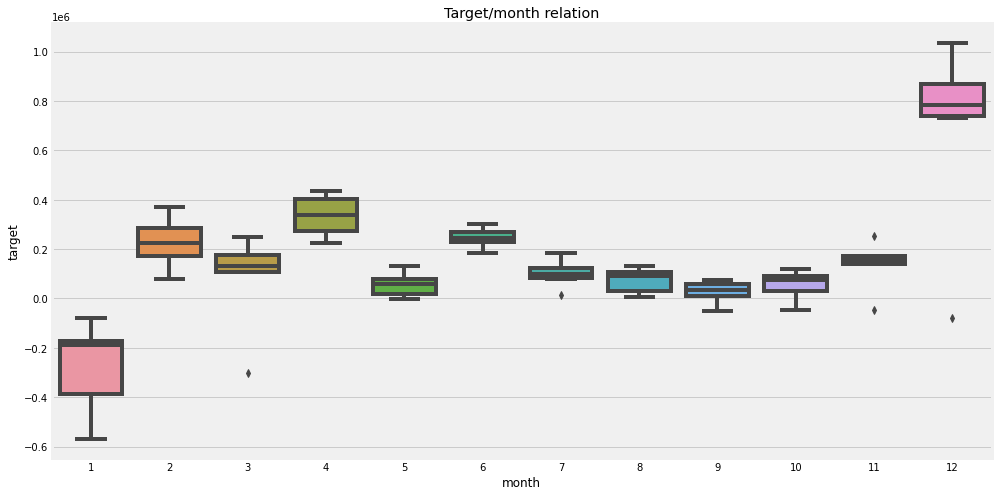

In [16]:
plot_feature_target_relationship('month')

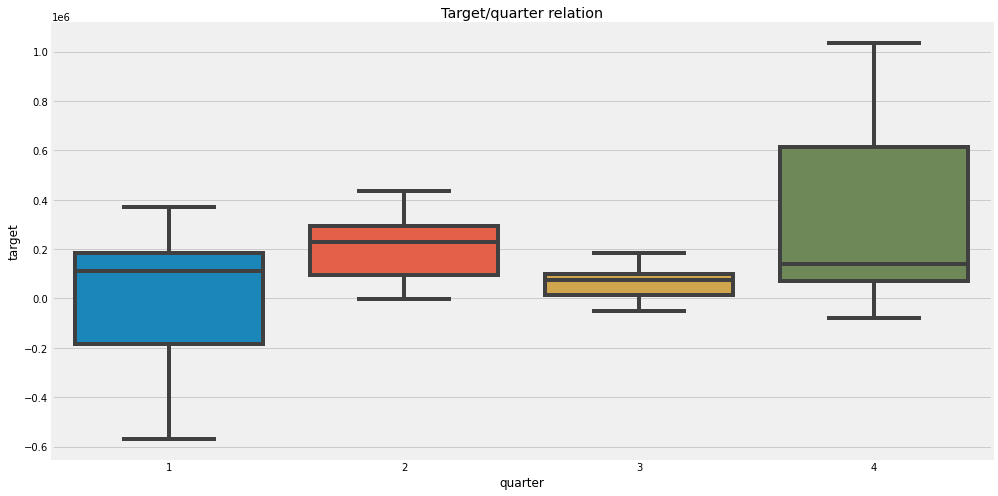

In [17]:
plot_feature_target_relationship('quarter')

## Modeling

In [18]:
from sklearn.metrics import mean_absolute_error

In [19]:
train = create_features(train)
test = create_features(test)

In [20]:
# FEATURES = ['profitability', 'key_rate', 'dollar_rate', 'ruble_rate',
            # 'oil_rate', 'consumer_index', 'm0', 'm2', 'dollar2ruble', 'month']

FEATURES = ['profitability', 'key_rate', 'dollar_rate', 'ruble_rate', 
            'dollar2ruble', 'avg_salary', 'month']
TARGET = 'target'

# после нескольких раундов таких прогонок - я убрал фичи, которые мало привносят в модель
#   в целом для такого обьема данных лучше иметь наименьшее возможное кол-во фич

In [21]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [22]:
reg = xgb.XGBRegressor(n_estimators=1000, learning_rate = 0.002)
reg.fit(
    x_train, y_train,
    eval_set=([x_train, y_train], [x_test, y_test]),
    early_stopping_rounds = 50,
    verbose = 100
        )

[0]	validation_0-rmse:286809.10498	validation_1-rmse:337975.27716
[100]	validation_0-rmse:246701.52159	validation_1-rmse:295601.03500
[200]	validation_0-rmse:212942.76068	validation_1-rmse:261320.22036
[300]	validation_0-rmse:184499.64136	validation_1-rmse:233157.76200


c:\Users\3mpti\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[400]	validation_0-rmse:160520.54051	validation_1-rmse:210336.28094
[500]	validation_0-rmse:140086.07324	validation_1-rmse:192923.40233
[600]	validation_0-rmse:122733.51448	validation_1-rmse:179067.65190
[700]	validation_0-rmse:108091.31991	validation_1-rmse:167889.12744
[800]	validation_0-rmse:95735.73004	validation_1-rmse:159392.37890
[900]	validation_0-rmse:85455.88849	validation_1-rmse:151953.20558
[999]	validation_0-rmse:76732.54612	validation_1-rmse:148976.56118


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.002, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

## Feature importance

In [23]:
reg.feature_importances_

array([0.1321291 , 0.04226495, 0.12672317, 0.10350117, 0.06851839,
       0.07208701, 0.4547762 ], dtype=float32)

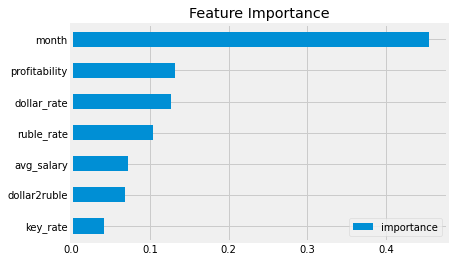

In [24]:
fi = pd.DataFrame(data = reg.feature_importances_,
                    index = reg.feature_names_in_,
                    columns = ['importance'])
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

## Forecasting

In [25]:
test['prediction'] = reg.predict(x_test)

In [26]:
df_i = df.copy()
df_i = df_i.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)

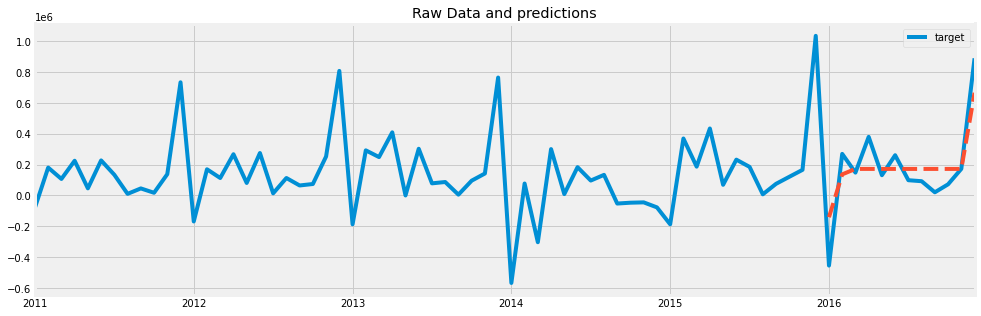

In [27]:
ax = df_i[['target']].plot(figsize = (15,5))
df_i['prediction'].plot(ax = ax, style = '--')
ax.set_title('Raw Data and predictions')
plt.show()

Well this is interesting but its not that good tbh... Adding lag features might help

## Cross validation

In [28]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()

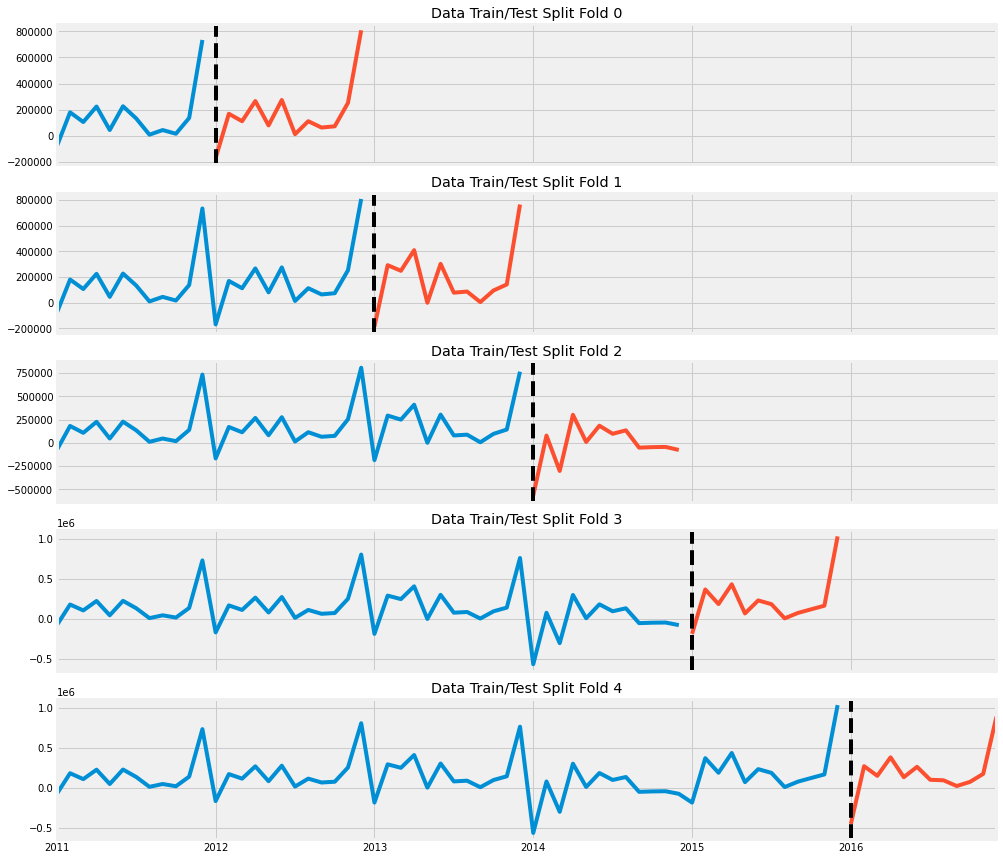

In [29]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['target'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['target'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()


Lag features for time series prediction is great!  

Put simply: we use known data from a year-two-three ago as a feature

In [30]:
def add_lags(df):
    target_map = df['target'].to_dict()
    df['lag1'] = (df.index - pd.DateOffset(years=1)).map(target_map)
    df['lag2'] = (df.index - pd.DateOffset(years=2)).map(target_map)
    df['lag3'] = (df.index - pd.DateOffset(years=3)).map(target_map)
    return df

In [31]:
df = add_lags(df)

In [32]:
from sklearn.metrics import mean_squared_error

Cross validation with lags

In [33]:
tss = TimeSeriesSplit(n_splits=5)

df = df.sort_index()

fold = 0
preds = []
scores = []

FEATURES = ['profitability', 'key_rate', 'dollar_rate', 'ruble_rate',
                'dollar2ruble', 'avg_salary', 'month', 'lag1', 'lag2', 'lag3']

TARGER = 'target'

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                    n_estimators=1000,
                    early_stopping_rounds=50,
                    objective='reg:linear',
                    max_depth=3,
                    learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    

[22:14:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:245549.71214	validation_1-rmse:282213.51997
[100]	validation_0-rmse:144084.07433	validation_1-rmse:260508.94618
[129]	validation_0-rmse:124082.04823	validation_1-rmse:267613.22184
[22:14:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:263810.71664	validation_1-rmse:295972.03578
[100]	validation_0-rmse:138298.79208	validation_1-rmse:190965.60013
[193]	validation_0-rmse:81440.61477	validation_1-rmse:190639.48116
[22:14:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/

In [34]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')


Score across folds 232599.8251
Fold scores:[258537.78312168026, 186416.9642735857, 216919.4879771723, 336336.68180895515, 164788.20841583548]


Well, it works I guess...

## Predicting le furute

In [35]:
df = create_features(df)

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)


[22:14:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:294189.29496
[100]	validation_0-rmse:154595.38520
[200]	validation_0-rmse:97026.03488
[300]	validation_0-rmse:71415.65304
[400]	validation_0-rmse:57295.67086
[499]	validation_0-rmse:47690.27401


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

In [36]:
reg.feature_importances_

array([0.11316821, 0.0398639 , 0.05308677, 0.0368709 , 0.03525047,
       0.05433394, 0.46556103, 0.04323279, 0.08099693, 0.07763493],
      dtype=float32)

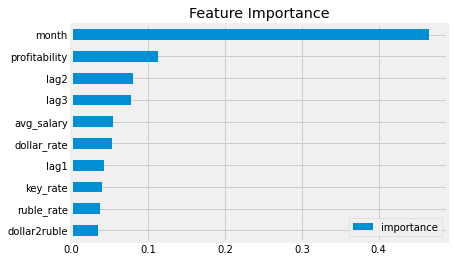

In [37]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()


In [38]:
df_pred['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, df_pred])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()

In [39]:
future_w_features['target'] = reg.predict(future_w_features[FEATURES])

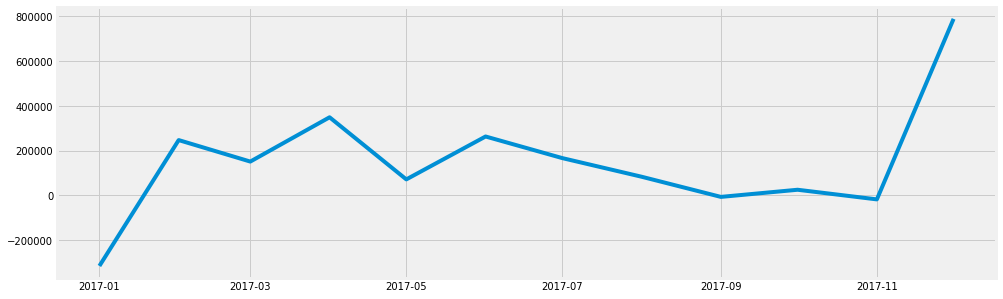

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))
# ax.ticklabel_format(style='plain')
ax.plot(future_w_features['target'])
plt.show()

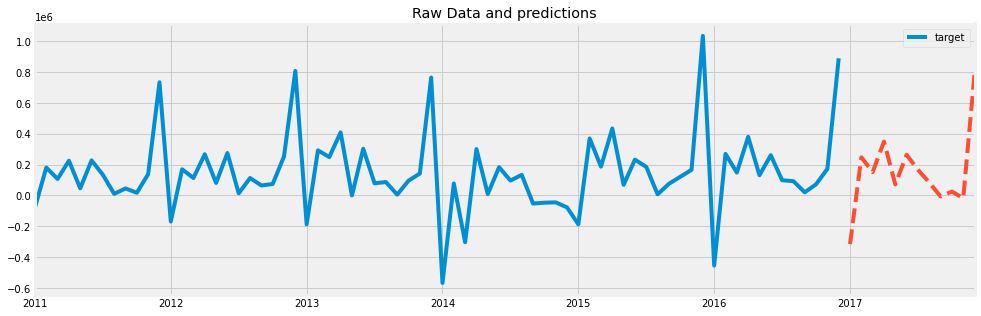

In [41]:
ax = df[['target']].plot(figsize=(15, 5))
future_w_features['target'].plot(ax=ax, style='--')
ax.set_title('Raw Data and predictions')
plt.show()
# prediction graph

In [42]:
future_w_features['target']
# predictions

2017-01-01   -315396.84
2017-02-01    247110.28
2017-03-01    151102.86
2017-04-01    349023.69
2017-05-01     71433.12
2017-06-01    263178.50
2017-07-01    166583.84
2017-08-01     83348.20
2017-09-01     -6787.63
2017-10-01     25125.85
2017-11-01    -17917.33
2017-12-01    788942.06
Name: target, dtype: float32

In [50]:
df_res = pd.concat([df, future_w_features])
df_res = df_res.drop(columns = ['lag1', 'lag2', 'lag3', 'isFuture', 'month', 'quarter', 'year'])
df_res = df_res.rename(columns={
    'target' :'Прирост вкладов физических лиц в рублях (млн руб)',
    'profitability' :'Доходность ОФЗ по сроку до 1 года',
    'key_rate' :'Ключевая ставка',
    'dollar_rate' :'Ставка по вкладам в долларах до 1 года',
    'ruble_rate': 'Ставка по вкладам в рублях до 1 года',
    'oil_rate' :'Нефть марки Юралс, долл./барр',
    'consumer_index' :'Индекс потребительских цен, ед.',
    'm0' :'М0, млрд руб',
    'm2' :'М2, млрд руб',
    'dollar2ruble' :'Курс доллара к рублю, руб',
    'avg_salary' :'Номинальная средняя з/п, руб',
}
)
df_res.to_csv('predictions_time_series.csv')